In [73]:
import s2sphere
from itertools import combinations
from itertools import chain
import shapefile
import numpy as np
from shapely.geometry import Polygon, Point, shape
from rasterstats import zonal_stats, point_query
import pandas as pd
import s2sphere
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

In [2]:
def find_1_neighbour(cell_id_str):
    new_cellid =s2sphere.CellId.from_token(cell_id_str)
    sxzy = new_cellid.get_edge_neighbors()
    comb = combinations(sxzy,2)
    corner = []
    for i in comb:
        common = list(set(i[0].get_edge_neighbors()).intersection(i[1].get_edge_neighbors()))
        corner.append(common)
    corner = list(chain(*corner))
    corner = list(filter(lambda a: a != new_cellid, corner))
    first_neighbor = list(sxzy) + corner
    return(first_neighbor)

In [3]:
def find_2_neighbour(first_neighbor, cell_id_str):
    new_cellid =s2sphere.CellId.from_token(cell_id_str)
    first_sxzy = []
    for cellid in first_neighbor:
        first_sxzy = first_sxzy + list(cellid.get_edge_neighbors())
    first_sxzy = list(set(first_sxzy) - set(first_neighbor))
    first_sxzy = list(filter(lambda a: a != new_cellid, first_sxzy))
    comb_2 = combinations(first_sxzy,2)
    corner_2 = []
    for i in comb_2:
        common = list(set(i[0].get_edge_neighbors()).intersection(i[1].get_edge_neighbors()))
        corner_2.append(common)
    corner_2 = list(chain(*corner_2))
    corner_2 = list(set(corner_2)- set(first_neighbor)- set(first_sxzy))
    second_neighbor = first_sxzy + corner_2
    return(second_neighbor)

In [4]:
def s2_cov(cell_list, rasterfile):
    values  =  []
    for ids in cell_list[:]:
        new_cell = s2sphere.Cell(s2sphere.CellId.from_token(str(ids)))
        vertices = []
        for i in range(0, 4):
            vertex = new_cell.get_vertex(i)
            latlng = s2sphere.LatLng.from_point(vertex)
            vertices.append((latlng.lng().degrees,latlng.lat().degrees))
        geo = Polygon(vertices)
        point_est = point_query(geo.centroid, rasterfile)
        values = values + point_est
    return values

In [5]:
def pop_w_neighbor(id_list, pop_raster):
    pop = 0
    new_id = []
    for cellid in id_list:
        sid = str(cellid)[8:15]
        new_id.append(sid)
    pop = s2_cov(new_id, pop_raster)
    return(pop)

In [98]:
def neighbour_pop(idlist):
    home_pop = s2_cov(idlist, pop_raster)
    first_pop_sum = []
    second_pop_sum = []
    for cell in idlist:
        first_neighbour = find_1_neighbour(cell)
        second_neighbour = find_2_neighbour(first_neighbour, cell)
        first_ngb_pop = pop_w_neighbor(first_neighbour, pop_raster)
        second_ngb_pop = pop_w_neighbor(second_neighbour, pop_raster)
        first_ngb_pop = pd.Series(first_ngb_pop, dtype=object).fillna(0).tolist()
        second_ngb_pop = pd.Series(second_ngb_pop, dtype=object).fillna(0).tolist()
        first_pop_sum.append(sum(first_ngb_pop))
        second_pop_sum.append(sum(second_ngb_pop))
    results = pd.DataFrame({'home_pop':home_pop,'first_pop_sum':first_pop_sum, 'second_pop_sum':second_pop_sum})
    return(results)

In [39]:
def scatter_plot_with_correlation_line(x, y, graph_filepath):
    '''
    http://stackoverflow.com/a/34571821/395857
    x does not have to be ordered.
    '''
    # Scatter plot
    plt.scatter(x, y)

    # Add correlation line
    axes = plt.gca()
    m, b = np.polyfit(x, y, 1)
    X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
    plt.plot(X_plot, m*X_plot + b, '-')

    # Save figure
    plt.savefig(graph_filepath, dpi=300, format='png', bbox_inches='tight')

In [9]:
pop_raster = "/Users/qianzh/project/human_mobility/data/covariates/population/worldpop_total_1y_2016_00_00.tif"

In [7]:
swaziland = pd.read_csv("/Users/qianzh/project/TaR/trial/swaziland/movement_home_in_Swaziland.csv")
swaziland_pop = neighbour_pop(swaziland['s2_id'])
swaziland_pop['s2_id'] = swaziland['s2_id']
swaziland_pop['prop_home'] = swaziland['prop_home']

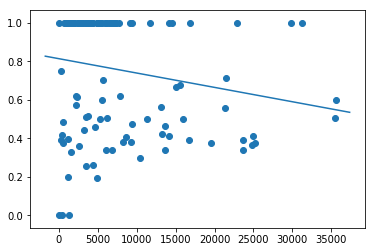

In [66]:
Y = swaziland_pop['prop_home']
X = swaziland_pop['home_pop']
scatter_plot_with_correlation_line(X, Y, "/Users/qianzh/project/TaR/trial/swaziland_home.png")

In [74]:
est_model = sm.OLS(Y, sm.add_constant(X))
est = est_model.fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:              prop_home   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     4.612
Date:                Mon, 27 Aug 2018   Prob (F-statistic):             0.0337
Time:                        09:33:04   Log-Likelihood:                -25.334
No. Observations:                 127   AIC:                             54.67
Df Residuals:                     125   BIC:                             60.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8140      0.037     21.975      0.0

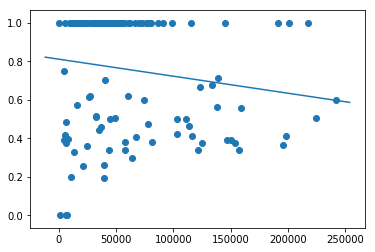

In [78]:
Y1 = swaziland_pop['prop_home']
X1 = swaziland_pop['home_pop'] + swaziland_pop['first_pop_sum']
scatter_plot_with_correlation_line(X1, Y1, "/Users/qianzh/project/TaR/trial/swaziland_first.png")

In [82]:
est1_model = sm.OLS(Y1, sm.add_constant(X1))
est1 = est1_model.fit()
print(est1.summary())

                            OLS Regression Results                            
Dep. Variable:              prop_home   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.182
Date:                Mon, 27 Aug 2018   Prob (F-statistic):             0.0769
Time:                        09:46:08   Log-Likelihood:                -26.039
No. Observations:                 127   AIC:                             56.08
Df Residuals:                     125   BIC:                             61.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8114      0.040     20.313      0.0

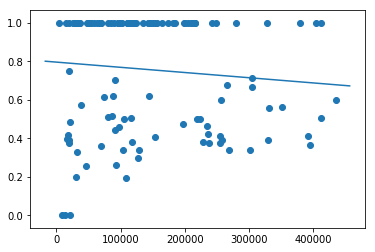

In [42]:
Y2 = swaziland_pop['prop_home']
X2 = swaziland_pop['home_pop'] + swaziland_pop['first_pop_sum'] + swaziland_pop['second_pop_sum']
scatter_plot_with_correlation_line(X2, Y, "/Users/qianzh/project/TaR/trial/swaziland_second.png")

In [107]:
est2_model = sm.OLS(Y2, sm.add_constant(X2))
est2 = est2_model.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              prop_home   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.163
Date:                Mon, 27 Aug 2018   Prob (F-statistic):              0.283
Time:                        12:42:29   Log-Likelihood:                -27.047
No. Observations:                 127   AIC:                             58.09
Df Residuals:                     125   BIC:                             63.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7962      0.044     18.004      0.0

In [99]:
south_africa = pd.read_csv("/Users/qianzh/project/TaR/trial/south_africa/movement_home_in_South Africa.csv")
south_africa_pop = neighbour_pop(south_africa['s2_id'])
south_africa_pop['s2_id'] = south_africa['s2_id']
south_africa_pop['prop_home'] = south_africa['prop_home']

/Users/qianzh/anaconda3/lib/python3.5/site-packages/rasterstats/point.py:167: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, nodata=nodata, affine=affine, band=band) as rast:
/Users/qianzh/anaconda3/lib/python3.5/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)


/Users/qianzh/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


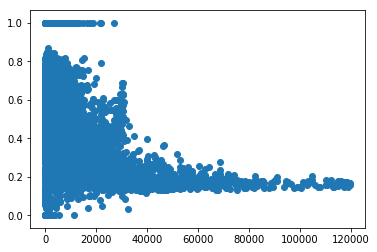

In [93]:
Y3 = south_africa_pop['prop_home']
X3 = south_africa_pop['home_pop'] 
scatter_plot_with_correlation_line(X3, Y3, "/Users/qianzh/project/TaR/trial/south_africa_pop_home.png")

In [84]:
est3_model = sm.OLS(Y3, sm.add_constant(X3))
est3 = est3_model.fit()
print(est3.summary())

                            OLS Regression Results                            
Dep. Variable:              prop_home   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 27 Aug 2018   Prob (F-statistic):                nan
Time:                        09:53:39   Log-Likelihood:                    nan
No. Observations:               53411   AIC:                               nan
Df Residuals:                   53411   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

/Users/qianzh/anaconda3/lib/python3.5/site-packages/statsmodels/base/data.py:131: RuntimeWarning: invalid value encountered in reduce
  const_idx = np.where(self.exog.ptp(axis=0) == 0)[0].squeeze()
/Users/qianzh/anaconda3/lib/python3.5/site-packages/statsmodels/tools/tools.py:346: RuntimeWarning: invalid value encountered in reduce
  cutoff = rcond * np.maximum.reduce(s)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/numpy/linalg/linalg.py:1647: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure

/Users/qianzh/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


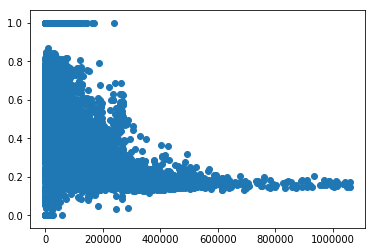

In [101]:
Y4 = south_africa_pop['prop_home']
X4 = south_africa_pop['home_pop'] + south_africa_pop['first_pop_sum']
scatter_plot_with_correlation_line(X4, Y4, "/Users/qianzh/project/TaR/trial/south_africa_pop_first.png")

In [95]:
est4_model = sm.OLS(Y4, sm.add_constant(X4))
est4 = est4_model.fit()
print(est4.summary())

                            OLS Regression Results                            
Dep. Variable:              prop_home   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 27 Aug 2018   Prob (F-statistic):                nan
Time:                        10:18:52   Log-Likelihood:                    nan
No. Observations:               53411   AIC:                               nan
Df Residuals:                   53411   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

/Users/qianzh/anaconda3/lib/python3.5/site-packages/statsmodels/base/data.py:131: RuntimeWarning: invalid value encountered in reduce
  const_idx = np.where(self.exog.ptp(axis=0) == 0)[0].squeeze()
/Users/qianzh/anaconda3/lib/python3.5/site-packages/statsmodels/tools/tools.py:346: RuntimeWarning: invalid value encountered in reduce
  cutoff = rcond * np.maximum.reduce(s)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/numpy/linalg/linalg.py:1647: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure

/Users/qianzh/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


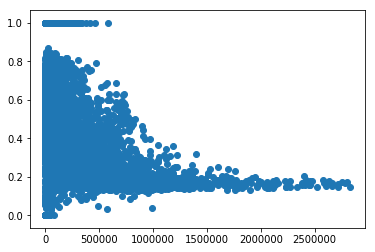

In [102]:
Y5 = south_africa_pop['prop_home']
X5 = south_africa_pop['home_pop'] + south_africa_pop['first_pop_sum'] + south_africa_pop['second_pop_sum']
scatter_plot_with_correlation_line(X5, Y5, "/Users/qianzh/project/TaR/trial/south_africa_pop_second.png")

In [103]:
est5_model = sm.OLS(Y5, sm.add_constant(X5))
est5 = est5_model.fit()
print(est5.summary())

                            OLS Regression Results                            
Dep. Variable:              prop_home   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 27 Aug 2018   Prob (F-statistic):                nan
Time:                        11:52:00   Log-Likelihood:                    nan
No. Observations:               53411   AIC:                               nan
Df Residuals:                   53411   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

/Users/qianzh/anaconda3/lib/python3.5/site-packages/statsmodels/base/data.py:131: RuntimeWarning: invalid value encountered in reduce
  const_idx = np.where(self.exog.ptp(axis=0) == 0)[0].squeeze()
/Users/qianzh/anaconda3/lib/python3.5/site-packages/statsmodels/tools/tools.py:346: RuntimeWarning: invalid value encountered in reduce
  cutoff = rcond * np.maximum.reduce(s)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/numpy/linalg/linalg.py:1647: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure

In [104]:
mozambique = pd.read_csv("/Users/qianzh/project/TaR/trial/mozambique/movement_home_in_Mozambique.csv")
mozambique_pop = neighbour_pop(mozambique['s2_id'])
mozambique_pop['s2_id'] = mozambique['s2_id']
mozambique_pop['prop_home'] = mozambique['prop_home']

/Users/qianzh/anaconda3/lib/python3.5/site-packages/rasterstats/point.py:167: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, nodata=nodata, affine=affine, band=band) as rast:
/Users/qianzh/anaconda3/lib/python3.5/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)


/Users/qianzh/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


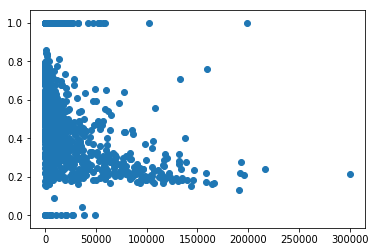

In [105]:
Y6 = mozambique_pop['prop_home']
X6 = mozambique_pop['home_pop']
scatter_plot_with_correlation_line(X6, Y6, "/Users/qianzh/project/TaR/trial/mozambique_pop_home.png")

In [106]:
est6_model = sm.OLS(Y6, sm.add_constant(X6))
est6 = est6_model.fit()
print(est6.summary())

                            OLS Regression Results                            
Dep. Variable:              prop_home   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 27 Aug 2018   Prob (F-statistic):                nan
Time:                        12:42:05   Log-Likelihood:                    nan
No. Observations:                2478   AIC:                               nan
Df Residuals:                    2478   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

/Users/qianzh/anaconda3/lib/python3.5/site-packages/statsmodels/base/data.py:131: RuntimeWarning: invalid value encountered in reduce
  const_idx = np.where(self.exog.ptp(axis=0) == 0)[0].squeeze()
/Users/qianzh/anaconda3/lib/python3.5/site-packages/statsmodels/tools/tools.py:346: RuntimeWarning: invalid value encountered in reduce
  cutoff = rcond * np.maximum.reduce(s)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/numpy/linalg/linalg.py:1647: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure

/Users/qianzh/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


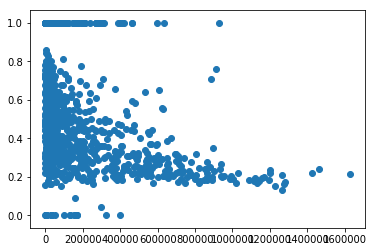

In [108]:
Y7 = mozambique_pop['prop_home']
X7 = mozambique_pop['home_pop'] + mozambique_pop['first_pop_sum']
scatter_plot_with_correlation_line(X7, Y7, "/Users/qianzh/project/TaR/trial/mozambique_pop_first.png")

In [109]:
est7_model = sm.OLS(Y7, sm.add_constant(X7))
est7 = est7_model.fit()
print(est7.summary())

                            OLS Regression Results                            
Dep. Variable:              prop_home   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 27 Aug 2018   Prob (F-statistic):                nan
Time:                        12:44:17   Log-Likelihood:                    nan
No. Observations:                2478   AIC:                               nan
Df Residuals:                    2478   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

/Users/qianzh/anaconda3/lib/python3.5/site-packages/statsmodels/base/data.py:131: RuntimeWarning: invalid value encountered in reduce
  const_idx = np.where(self.exog.ptp(axis=0) == 0)[0].squeeze()
/Users/qianzh/anaconda3/lib/python3.5/site-packages/statsmodels/tools/tools.py:346: RuntimeWarning: invalid value encountered in reduce
  cutoff = rcond * np.maximum.reduce(s)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/numpy/linalg/linalg.py:1647: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure

/Users/qianzh/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


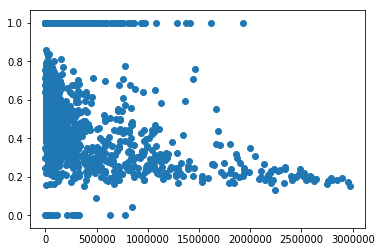

In [110]:
Y8 = mozambique_pop['prop_home']
X8 = mozambique_pop['home_pop'] + mozambique_pop['first_pop_sum'] + mozambique_pop['second_pop_sum']
scatter_plot_with_correlation_line(X8, Y8, "/Users/qianzh/project/TaR/trial/mozambique_pop_second.png")

In [111]:
est8_model = sm.OLS(Y8, sm.add_constant(X8))
est8 = est8_model.fit()
print(est8.summary())

                            OLS Regression Results                            
Dep. Variable:              prop_home   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 27 Aug 2018   Prob (F-statistic):                nan
Time:                        12:46:26   Log-Likelihood:                    nan
No. Observations:                2478   AIC:                               nan
Df Residuals:                    2478   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

/Users/qianzh/anaconda3/lib/python3.5/site-packages/statsmodels/base/data.py:131: RuntimeWarning: invalid value encountered in reduce
  const_idx = np.where(self.exog.ptp(axis=0) == 0)[0].squeeze()
/Users/qianzh/anaconda3/lib/python3.5/site-packages/statsmodels/tools/tools.py:346: RuntimeWarning: invalid value encountered in reduce
  cutoff = rcond * np.maximum.reduce(s)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/numpy/linalg/linalg.py:1647: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/qianzh/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure